# Report 



Repport of the first day of experiment at Lautaret:

**Who** : Charles.A, Laurent.A, Glenn.P, Kevin.F, Catherine.C, Hélène. ,Philipe.D

**Where** : Flux Alpes

**Task** :
* TDR Installation
* Density profile
* SSA profile : ASSAP
* Liquid Water Content profile : WISe
* Spectral albedo surface : Solab
    

## Import of libraries

In [2]:
# ================ IMPORTATIONS ================ #

### DATA MANIPULATION ###

import pandas as pd # used to manipulate 2D data into the data-frame

import numpy as np # useful to handle matrix like datasets

import seaborn as sns # useful for statistics

### DATA REPRESENTATION ###

import matplotlib.pyplot as plt # used for makings nice plots

### PERSONAL SCRIPT ###

import sys
import os

# Ajoute le dossier parent du notebook au sys.path
sys.path.append(os.path.abspath("../../.."))  # Monte d'un niveau

from scripts.Comput import *

print("Good you've imported the necessary libraries.")

Good you've imported the necessary libraries.


## TDR Instalation
Schem which explain the location of each TDR in the snow pack of 178 cm at 18/03/2025

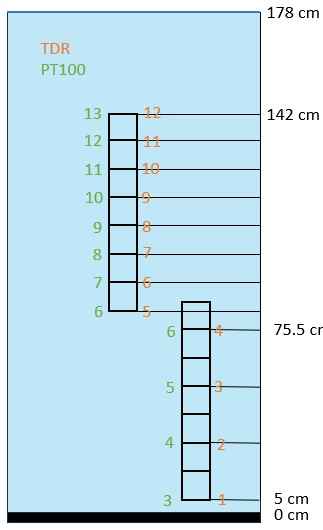



In [3]:
df_TDR_PT100_location = pd.DataFrame({'Z' : [5.5,25.5,45.5,65.5,82,92,102,112,122,132,142] ,'TDR number' : [1,2,3,4,5,6,7,8,9,10,11], 'PT100 number' : [3,4,5,6,7,8,9,10,11,12,13]})
df_TDR_PT100_location

,Z,TDR number,PT100 number
0,5.5,1,3
1,25.5,2,4
2,45.5,3,5
3,65.5,4,6
4,82.0,5,7
5,92.0,6,8
6,102.0,7,9
7,112.0,8,10
8,122.0,9,11
9,132.0,10,12


## General values

In [4]:
thickness = 1.78 # thickness of snow [m]

# Folder where all the mesears are stack
data_folder = "~/private-storage/Experiences/Lautaret/Lautaret-17-03-2025-Instalation-TDR/data/"

## Density profil with cutter

The density profil was measure by density cutter each 5 cm:

Weight of snow cutter : 457 g

Comment: 
* Z = 134 : Ice slab 3-4 cm
* Z = 64 : to hard to measure
* Z = 44,39,24 to hard
* Z = 4 ground with slope, impossible to measure

In [5]:
# General values
w_sc = 0.457 # Weight of snow cutter without snow [g]

# Definition profil of snow cutter weight with snow.
file_name = "Cutter_weight_profile.csv"
df_density = pd.read_csv(data_folder+file_name, delimiter=';')
# Conversion into density: density = weight / volume with
df_density['density [kg/m3]'] = (df_density['Cutter_weight_[g]'] - w_sc*1000) * 4
df_density = df_density.drop(columns=['Cutter_weight_[g]'])

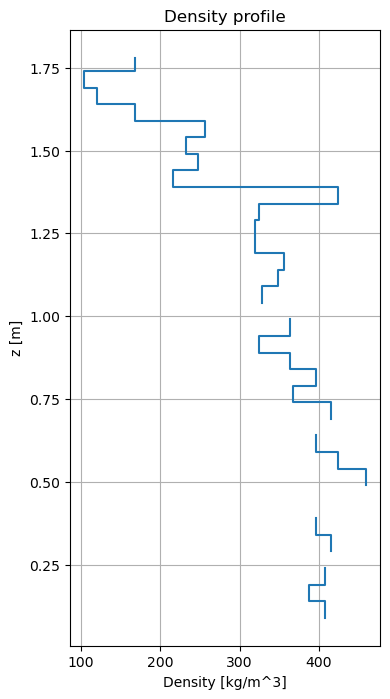

In [6]:
def generate_step_values_for_density_plot(x_points, y_points,thickness):
    '''
    Processed data for generation of density plot

    Input
    x_point : List of mesures beging at the top oh the snow layer 
    y_point : List of elevation for each values of mesures begining at the top

    Output:
    x_values, yvalues for plot of step
    '''
    
    x_values = [x_points[0],x_points[0]]  # On commence à x = 0
    y_values = [thickness,y_points[0]]  # Première valeur de y

    for i in range(len(x_points)):
        x_values.extend([x_points[i], x_points[i]])
        y_values.extend([y_points[i], y_points[i] if i < len(y_points) - 1 else None])

    x_values.pop()  # Supprime le dernier élément inutile de x_values
    y_values.pop()  # Supprime le dernier élément inutile de y_values

    return x_values, y_values

# PLOT ####################################################################################################################
plt.figure(figsize=(4, 8))
x,y = generate_step_values_for_density_plot(df_density['density [kg/m3]'],df_density.Z*10e-3,thickness)
plt.step(x,y,where='post')
# Labels and titles

plt.xlabel('Density [kg/m^3]')
plt.ylabel('z [m]')
plt.title("Density profile")
plt.grid()

## Liquid water content profil with WISe

The Liquid water content profil was measure by WISe each 5cm:

Explication Ambach :




[0.06292812]


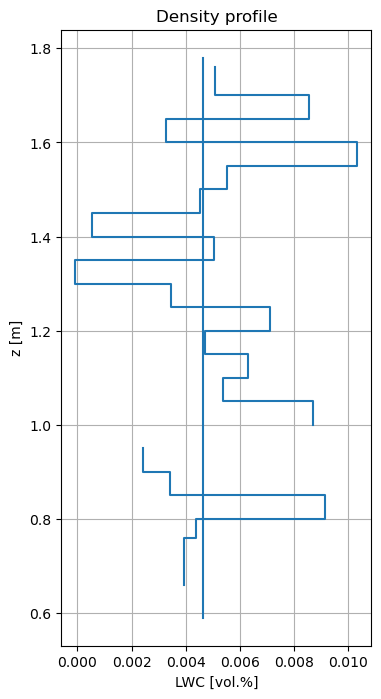

In [12]:
# Creat a data frame with all measures.
file_name = "LWC_profile.csv"
df_LWC_profile = pd.read_csv(data_folder+file_name, delimiter=';')
########################################################################################################
# Convert permittivy with density into Liquid Water content. 
########################################################################################################

# First step we need to merge closer values of permitivity and density respect to elveation. ###########

# Sauvegarde de l'ordre initial
df_LWC_profile['_order'] = range(len(df_LWC_profile))

# Fusion en triant temporairement les DataFrames
df_LWC_profile = pd.merge_asof(
            df_LWC_profile.sort_values('Z'),
            df_density.sort_values('Z'),
            on='Z',
            direction='nearest')
# Restauration de l'ordre d'origine
df_LWC_profile = df_LWC_profile.sort_values('_order').drop(columns=['_order'])


# Comput Liquid water content with Ambach and Dent law##################################################

def Ambach_Dent(Perm,D_bulk):
    '''From Ambacht et Dent (1980)
    Permitivity : List dialectric permittivity 
    Density_bulk : List bulk density [kg/m^3]
    return
    lwc : liquid water content 
    '''
    Perm = np.array(Perm)
    D_bulk = np.array(D_bulk)
    Lwc = D_bulk*0
    for i in range(5):
        Ds = D_bulk/1000 - Lwc
        Lwc = (Perm- 1 - 1.202*Ds - 0.983*Ds**2)/21.3
    return Lwc

 #   𝑊𝑣 = (𝜀 - 1 – 1.202 * Ds – 0.983 * Ds²)/21.3

    
Perm = [2.269]
D_bulk = [0.350]
print(Ambach_Dent(Perm,D_bulk))
df_LWC_profile['LWC [vol%]'] = Ambach_Dent(df_LWC_profile['Permitivity'], df_LWC_profile['density [kg/m3]'])

######################################################################################################
# PLOT 
######################################################################################################
plt.figure(figsize=(4, 8))
x,y = generate_step_values_for_density_plot(df_LWC_profile['LWC [vol%]'],df_LWC_profile.Z*10e-3,thickness)
plt.step(x,y,where='post')
# Labels and titles

plt.xlabel('LWC [vol.%]')
plt.ylabel('z [m]')
plt.title("Density profile")
plt.grid()

In [ ]:
df_LWC_profile